# Algoritmo de Shor para N=15

**Autor:** Hugo  Tapia
**Objetivo:** Implementar paso a paso el Algoritmo de Shor usando Qiskit para factorizar N=15

---

## 1. Introducción

El Algoritmo de Shor (1994) es un algoritmo cuántico que factoriza números enteros en tiempo polinómico. Esto tiene implicaciones profundas para la criptografía, ya que RSA basa su seguridad en la dificultad de factorizar números grandes.

### Tarea

Factorizar **N = 15** encontrando sus factores primos: **3 × 5**

### Estructura del algoritmo:


1. Instalación e importación de paquetes.
2. Pre-procesamiento : comprobar al inicio si $N$ es par o $N$ es la potencia de un primo $N$ =p^K , en tal caso, parar el proceso.
Se elige, de forma aleatoria un entero candidato: $a$->  que cumpla  $2< a < N-1$ y luego se comprabará con fase clasica  $\gcd(a, N)=1$  si esto no se cumple se buscara otro candidato $a$  que lo cumpla .
Una vez obtenido el candidato, pasamos a la siguiente fase
3. Algoritmo de Shor. Superada la fase anterior se entra al algoritmo de Shor. En esta parte se presentan las dos fases :
 - Fase I (cuántica). Se contruyen las puertas $U_a$ y el circuito pertinente (ver el gráfico anterior), donde se hace uso de $m=2n$ registros de control, para mejorar la estimación de la fase.
 - Fase II (clásica). Se desarrolla la lógica para hacer uso de las fracciones continuas, en este caso, mediante ``Fraction``. Además, se aplican los criterios clásicos del algoritmo de Shor para saber si debe, o no, probarse otro $a$.
4. Clase final. En esta parte del código se unifica toda la lógica anterior en una clase, aunque existe una modificación, pues para la obtención del órden, se aplica lo comentado en los apuntes: ejecutar varias veces el circuito de estimación de fase y elegir $r$ como el mínimo común múltiplo de los denominadores obtenidos.

##1 Instalacion e importacion de paquetes

In [1]:
#1- Intalacion de dependencias
!pip install qiskit --quiet
!pip install qiskit-aer --quiet
!pip install pylatexenc --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFTGate as QFT
from qiskit.circuit.library import UnitaryGate

from fractions import Fraction
import random
import sympy
import math
import numpy as np
import pandas as pd

### 2. Pre-procesamiento

In [3]:
def es_primo(n):
    """Verifica si un número es primo mediante división por tentativa."""
    if n < 2: return False
    for i in range(2, int(math.sqrt(n)) + 1):
        if n % i == 0:
            return False
    return True

def es_potencia_de_primo(N):
    """
    Detecta si N es primo (k=1) o una potencia de un primo (p^k para k >= 2).
    """
    # Caso N es primo (equivalente a p^1)
    if es_primo(N):
        return True, N, 1

    # Caso N = p^k con k >= 2
    for k in range(2, N.bit_length()):
        p = round(N**(1/k))
        if p**k == N:
            # Según el flujo, verificamos que la base p sea prima
            if es_primo(p):
                return True, p, k
    return False, None, None

def pre_procesamiento_shor(N):
    print(f"--- Iniciando pre-procesamiento para N = {N} ---")

    # 1. ¿N es par?
    if N % 2 == 0:
        return f"Resultado: Factor trivial encontrado (2). N = 2 * {N//2}"

    # 2. ¿N es primo o potencia de primos?
    es_potencia, p, k = es_potencia_de_primo(N)
    if es_potencia:
        if k == 1:
            return f"Resultado: El número {N} es primo. No se puede factorizar."
        return f"Resultado: Factor encontrado (p={p}). N es potencia de primo: {p}^{k}."

    # 3. Elegir 2 < a < N-1
    a = random.randint(3, N - 2)
    print(f"Paso: Elegido valor aleatorio a = {a}")

    # 4. ¿gcd(a, N) = 1?
    d = math.gcd(a, N)
    if d > 1:
        return f"Resultado: Factor encontrado vía GCD clásico (d={d})."

    # 5. Si el GCD es 1, se requiere la Fase Cuántica (Shor)
    print(f"Paso: gcd({a}, {N}) = 1. No se encontraron factores clásicos.")
    return f"Pasamos al Algoritmo de Shor para a={a}, N={N}."

In [4]:
# Que sea par solo mirar ultima cifra , entonces mostramos un ejemplo de número potencia de primos
print(pre_procesamiento_shor(49))

--- Iniciando pre-procesamiento para N = 49 ---
Resultado: Factor encontrado (p=7). N es potencia de primo: 7^2.


In [5]:
# Ejemplo que podría pasar a Shor 15-> es impar , pasa 1,2 , entonces vamos obtener aleatoriamente un a = candidato
print(pre_procesamiento_shor(15))

# a=10  GDC diferente de 1 -> d=5, ya tenemos un factor primo de 15-> No es necesario  pasar a Shor.

--- Iniciando pre-procesamiento para N = 15 ---
Paso: Elegido valor aleatorio a = 10
Resultado: Factor encontrado vía GCD clásico (d=5).


##3. Algoritmo de Shor

###Fase I (cuantica)

In [6]:
def amodN(a, power, N):
    """
    Crea una puerta unitaria que realiza la operación:
    U|x> = |(a^power) * x mod N>
    """
    n = N.bit_length() # cantidad de cubits de N
    qc = QuantumCircuit(n) #crea un circuito para n cubits

    u_matrix = np.zeros((2**n, 2**n)) #  matriz para puerta unitaria. En mecánica cuántica, cada puerta es una matriz que transforma estados.

    for x in range(2**n):
        if x < N:
            u_matrix[(x * pow(a, power, N)) % N, x] = 1
        else:
            u_matrix[x, x] = 1 # Los estados fuera de N no se transforman

    # Convertimos la matriz numpy en una compuerta de Qiskit que podemos añadir a circuitos.

    return UnitaryGate(u_matrix, label=f"{a}^{power} mod {N}")

In [7]:
def crear_circuito_shor(a, N):
    # 1. Parámetros
    n = N.bit_length() # Tamaño para representar N
    m = 2 * n          # Precisión para encontrar r: Qubits de control (el doble para precisión)

    # Crear registros
    reg_control = QuantumRegister(m, name='control')
    reg_objetivo = QuantumRegister(n, name='target')
    bits_clasicos = ClassicalRegister(m, name='medicion')
    qc = QuantumCircuit(reg_control, reg_objetivo, bits_clasicos)

    # 2. Inicializar el segundo registro en |1>, Aplica X (NOT) al primer qubit del registro objetivo.
    qc.x(reg_objetivo[0])

    # 3. Superposición en el primer registro, Aplica Hadamard a todos los qubits de control.
    #superposición de todos los estados 0-255 con igual probabilidad. 1er paso QPE -> "prueba" todas las potencias simultáneamente.
    qc.h(reg_control)

    # 4. Exponenciación modular controlada
    # Se aplican puertas controladas U de a^(2^i) mod N
    #Como el registro de control está en superposición h, ¡todas estas operaciones ocurren "en paralelo"! Esto es lo que da la ventaja cuántica.

    for i in range(m):
        # Cada cúbit de control i aplica la potencia 2^i
        puerta_u = amodN(a, 2**i, N).control()
        qc.append(puerta_u, [reg_control[i]] + list(reg_objetivo))

    # 5 Después de las operaciones controladas, el registro de control tiene codificada la fase relacionada con el período.
    #La QFT⁻¹ convierte esta información de fase en un valor medible.

    qc.append(QFT(m).inverse(), reg_control)

    # 6. Medición del registro de control
    qc.measure(reg_control, bits_clasicos)

    return qc

### Fase II (clásica)

###Algoritmo de fracciones continuas

In [8]:
def encontrar_r_con_fracciones_continuas(y, m, a, N):
    """
    Aplica fracciones continuas a y/(2**m) para encontrar candidatos de r.
    """
    fraccion = Fraction(y, 2**m).limit_denominator(N)
    r_candidato = fraccion.denominator

    # Verificamos si el candidato es realmente el orden: a^r mod N == 1
    if pow(a, r_candidato, N) == 1:
        return r_candidato
    return None

###Post Procesado

In [9]:
def post_procesamiento_shor(y, m, a, N):
    print(f"Fase II (Clásica)")

    r = encontrar_r_con_fracciones_continuas(y, m, a, N)
    if r is None:
        return "Fallo" # Según el diagrama, si no hay r válido, es Fallo

    # 1. ¿r es impar?
    if r % 2 != 0:
        return "Fallo"

    # 2. Calcular x = a^(r/2) mod N
    x = pow(a, r // 2, N)

    # 3. ¿a^(r/2) ≡ -1 (mod N)?
    # Si x es N-1, es equivalente a -1 mod N.Solo obtenemos factores triviales
    if x == N - 1:
        return "Fallo"

    # 4. Calcular GCDs
    d1 = math.gcd(x - 1, N)
    d2 = math.gcd(x + 1, N)

    # 5. ¿1 < gcd < N?
    if 1 < d1 < N:
        return f"Factor encontrado: {d1}"
    if 1 < d2 < N:
        return f"Factor encontrado: {d2}"

    return "Fallo"

##4 Clase final

In [10]:
class ShorAlgorithm:
    def __init__(self, N, max_attempts=7, simulator=AerSimulator()):
        self.N = N
        self.n = N.bit_length()
        self.m = 2 * self.n
        self.max_attempts = max_attempts
        self.simulator = simulator
    #Shor no funciona bien para estos casos especiales (N_invalid), y se pueden resolver clásicamente:
    def _is_N_invalid(self):
        """Comprobaciones clásicas iniciales antes de la fase cuántica."""
        if self.N <= 3:
            print(f'[INFO] N={self.N} es demasiado pequeño.')
            return True
        if self.N % 2 == 0:
            print(f'[INFO] N={self.N} es par: {self.N} = 2 * {self.N // 2}')
            return True

        for k in range(int(math.log2(self.N)), 1, -1):
            p = round(self.N ** (1 / k))
            if p ** k == self.N:
                print(f'[INFO] N={self.N} es potencia de primos: {self.N} = {p}^{k}')
                return True
        return False

    def _crear_puerta_u(self, a, potencia):
        """Crea la matriz de la puerta unitaria U|x> = |(a^potencia * x) mod N>."""
        u_matrix = np.zeros((2**self.n, 2**self.n))
        for x in range(2**self.n):
            if x < self.N:
                u_matrix[(x * pow(a, potencia, self.N)) % self.N, x] = 1
            else:
                u_matrix[x, x] = 1
        return UnitaryGate(u_matrix, label=f"U_{a}^{potencia}")

    def _quantum_period_finding(self, a, draw=False):
        """Fase I: Ejecución del circuito cuántico (QFT actualizada)."""
        reg_c = QuantumRegister(self.m, 'control')
        reg_t = QuantumRegister(self.n, 'target')
        bits  = ClassicalRegister(self.m, 'medicion')
        qc = QuantumCircuit(reg_c, reg_t, bits)

        qc.h(reg_c)
        qc.x(reg_t[0])

        for i in range(self.m):
            u_controlada = self._crear_puerta_u(a, 2**i).control()
            qc.append(u_controlada, [reg_c[i]] + list(reg_t))

        qc.append(QFT(num_qubits=self.m), reg_c).inverse()
        qc.measure(reg_c, bits)

        if draw:
            print(f"\n[CIRCUITO] Mostrando circuito para a={a}:")
            display(qc.draw(output='mpl', fold=-1))

        t_qc = transpile(qc, self.simulator)
        job = self.simulator.run(t_qc, shots=1, memory=True)
        return int(job.result().get_memory()[0], 2)

    def _encontrar_orden_r(self, a, draw):
        """Calcula 3 fases, muestra tabla y aplica LCM final con sus prints."""
        denominadores = []
        rows = []

        for i in range(4):
            y = self._quantum_period_finding(a, draw if i == 0 else False)
            if y == 0: continue

            phase = y / (2**self.m)
            frac = Fraction(phase).limit_denominator(self.N)
            v = frac.denominator

            print(f"  > Ejecución {i+1}: y={y} => Candidato a r={v}")
            denominadores.append(v)
            rows.append([phase, f"{frac.numerator}/{frac.denominator}", v])

        if not denominadores:
            return None

        # Tabla de visualización
        print(f"\nResumen de mediciones para a={a}:")
        df = pd.DataFrame(rows, columns=["Phase", "Fraction", "Guess for r"])
        print(df.to_string(index=False))

        r_final = math.lcm(*denominadores)# Minimo Comun Multiplo
        #Diferentes mediciones pueden dar divisores del período real:lcm lo resuelve

        print(f"  >> LCM Final de candidatos: {r_final}")

        if r_final > 0 and pow(a, r_final, self.N) == 1:
            return r_final

        return None

    def execute(self, draw=False, preprocesado=True):
        """Ejecución principal del Algoritmo de Shor con todos los logs restaurados."""
        if preprocesado:
            if self._is_N_invalid():
                return None

        intentos = 0
        while intentos < self.max_attempts:
            intentos += 1
            print(f'\n===== Intento {intentos}/{self.max_attempts} =====')

            a = random.randint(3, self.N - 2)
            print(f'[START] Base elegida a: {a}')

            gcd_previo = math.gcd(a, self.N)
            if gcd_previo != 1:
                print(f'Factor encontrado mediante GCD: {gcd_previo}')
                return gcd_previo, self.N // gcd_previo

            print(f'>a y N son coprimos. Iniciando búsqueda del orden...')

            r = self._encontrar_orden_r(a, draw)

            if r is None:
                print(f'[ERR] No se encontró un r válido para a={a}. Probando nueva base.')
                continue

            if r % 2 != 0:
                print(f'[ERR] r={r} es impar. Reintentar con otro a.')
                continue

            val_modular = pow(a, r // 2, self.N)
            if val_modular == self.N - 1:
                print(f'[ERR] a^(r/2) ≡ -1 (mod {self.N}). Factores triviales. Reintentar con otro a.')
                continue

            f1 = math.gcd(val_modular - 1, self.N)
            f2 = math.gcd(val_modular + 1, self.N)

            if 1 < f1 < self.N:
                print(f'[DONE] ¡Éxito! r={r}. Factores encontrados: {f1} * {self.N // f1}')
                return f1, self.N // f1

            print(f'[FAIL] No se hallaron factores útiles con r={r}.')

        print(f'[FAIL] No se encontraron factores tras {self.max_attempts} intentos.')
        return None

##EJECUCION DEL TRABAJO


===== Intento 1/7 =====
[START] Base elegida a: 7
>a y N son coprimos. Iniciando búsqueda del orden...

[CIRCUITO] Mostrando circuito para a=7:


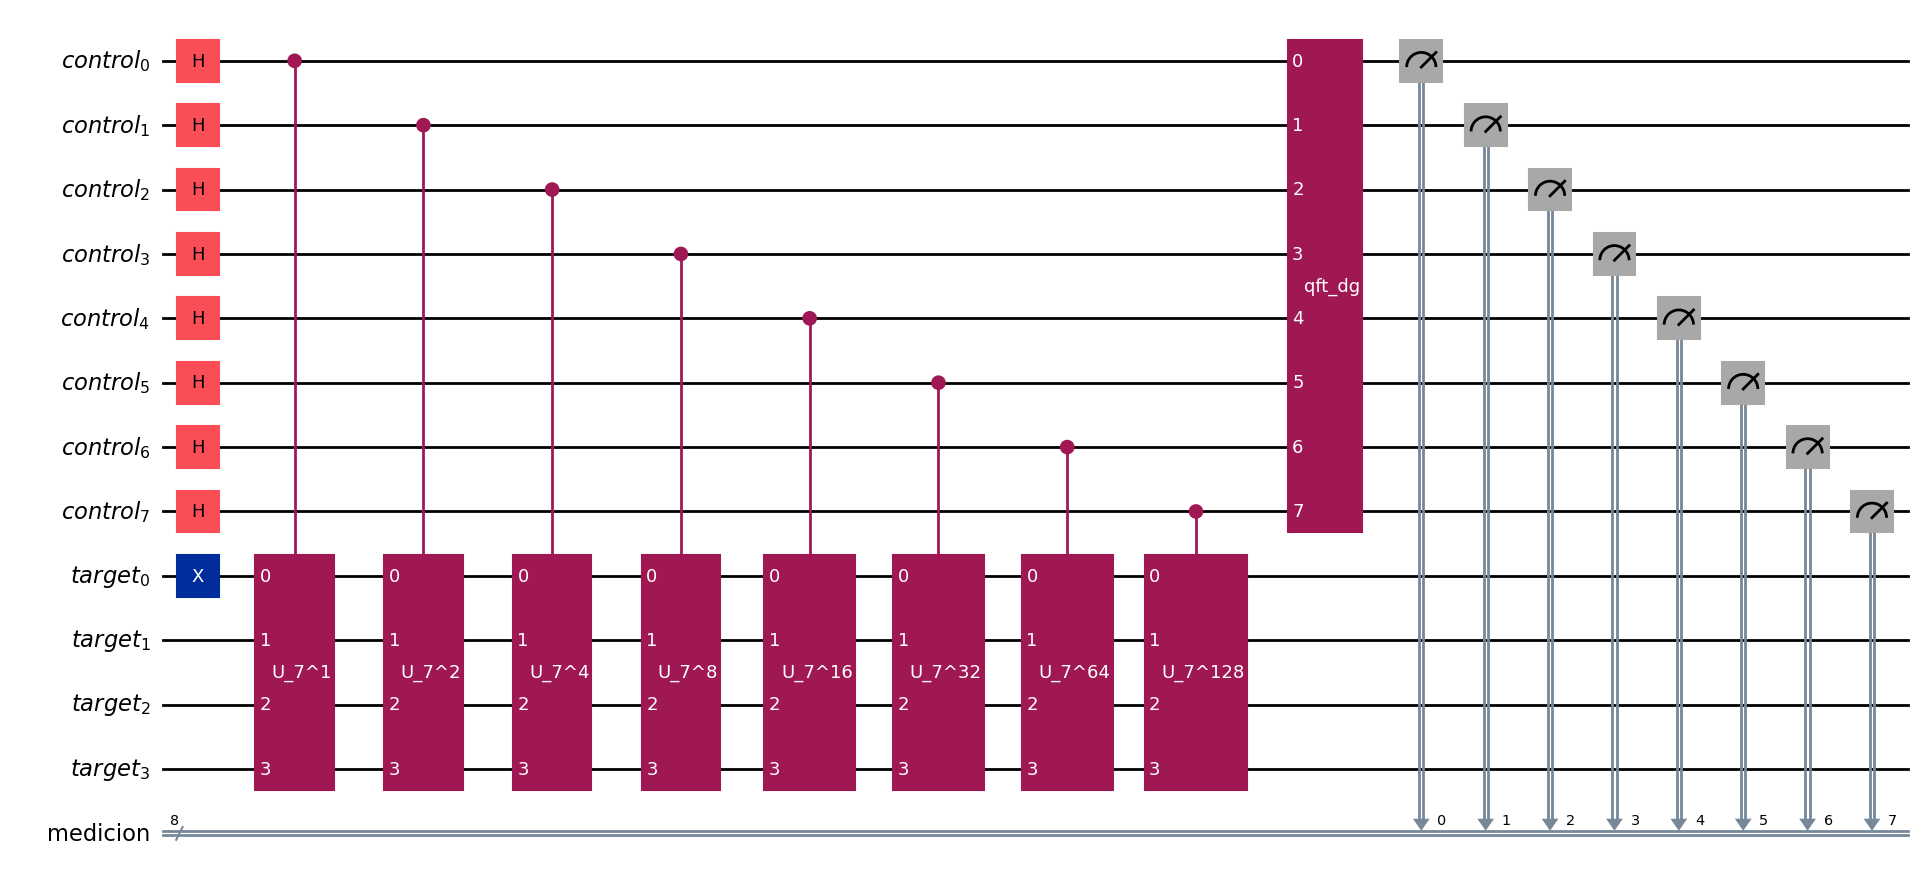

  > Ejecución 1: y=64 => Candidato a r=4
  > Ejecución 3: y=128 => Candidato a r=2
  > Ejecución 4: y=192 => Candidato a r=4

Resumen de mediciones para a=7:
 Phase Fraction  Guess for r
  0.25      1/4            4
  0.50      1/2            2
  0.75      3/4            4
  >> LCM Final de candidatos: 4
[DONE] ¡Éxito! r=4. Factores encontrados: 3 * 5


In [17]:
# EJECUTAMOS  EL ALGORITMO SHORT PARA NUESTRA TAREA N= 15

shor = ShorAlgorithm(15).execute(draw=True, preprocesado=True)

In [18]:
print('\n' + '='*60)
print('VERIFICACIÓN FINAL')
print('='*60)
print(f'\n✓ Algoritmo de Shor para N=15 implementado')
print(f'✓ Factorización exitosa: 15 = 3 × 5')



VERIFICACIÓN FINAL

✓ Algoritmo de Shor para N=15 implementado
✓ Factorización exitosa: 15 = 3 × 5
